In [24]:
import capnp
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path_to_schema = "/home/franziska/Documents/Master/sem1/argos-zero/src/capnp/CapnpGame.capnp"
path_to_game_folder = "/home/franziska/selfgames/"

In [3]:
schema = capnp.load(path_to_schema).Game


In [4]:
file_list = []
for file in os.listdir(path_to_game_folder):
    file_list.append(file)

In [129]:
def read_games(file_list):
    games = []
    
    for file in file_list:
        f = open(path_to_game_folder+file, 'rb') 
        game = schema.read(f)
        games.append(game)
        
    return games

In [130]:
games = read_games(file_list)

In [133]:
# filter games such that we only have games with no resignation
def get_games_without_res(games):
    games_without_res = []
    
    for game in games:
        if game.noresignmode:
            games_without_res.append(game)

    return games_without_res

In [134]:
games_without_res = get_games_without_res(games)

In [6]:
len(games_without_res)

387

In [7]:
def get_winrates_for_game(game):
    return [sp.winrate for sp in game.stateprobs]
    

In [8]:
def get_winrates_for_games_won_by_player(winrate_lists, player):
    """Returns the winrates for only the given player"""
    filtered_winrates_list = []
    for winrates in winrate_lists:
        filtered_winrates = []
        for i, winrate in enumerate(winrates):
            if i % 2 == player:
                filtered_winrates.append(winrate)
        filtered_winrates_list.append(filtered_winrates)
    return filtered_winrates_list

In [9]:
def get_games_won_by_player(games, player):
    games_won_by_player = []
    for game in games:
        if game.result == player:
            games_won_by_player.append(game)
    return games_won_by_player

In [10]:
def get_winrates_for_player(games, player):
    """Get the winrates only for this player in the games won by the player"""
    games_won_by_player = get_games_won_by_player(games, player)
    player_winrates = [get_winrates_for_game(game) for game in games_won_by_player]
    only_player_winrates = get_winrates_for_games_won_by_player(player_winrates, player)
    
    return only_player_winrates
    

In [14]:
games_won_by_black = get_games_won_by_player(games_without_res, 1)
games_won_by_white = get_games_won_by_player(games_without_res, 0)

In [15]:
black_winrates = [get_winrates_for_game(game) for game in games_won_by_black]
white_winrates = [get_winrates_for_game(game) for game in games_won_by_white]

In [18]:
only_black_winrates = get_winrates_for_games_won_by_player(black_winrates, 1)
only_white_winrates = get_winrates_for_games_won_by_player(white_winrates, 0)

In [12]:
black = get_winrates_for_player(games_without_res,1)
white = get_winrates_for_player(games_without_res,0)

dataset = black + white

In [13]:
def find_fn_count(threshold, winrate_lists):
    """winrates: list of lists"""
    return sum([any([1 - winrate <= threshold for winrate in winrates]) for winrates in winrate_lists])

In [56]:
find_fn_count(0.05, dataset)

49

In [95]:
len(dataset)

387

In [113]:
thresholds = np.linspace(0, 0.1, num=1000)

In [114]:
results = np.array([find_fn_count(threshold, dataset) for threshold in thresholds])
results = results / len(dataset)

In [122]:
best_i = np.where(results <= 0.05)[0][-1]

In [124]:
thresholds[best_i]

0.0065065065065065065

In [137]:
def compute_threshold(games, max_fn_rate):
    games = get_games_without_res(games)
    black = get_winrates_for_player(games_without_res,1)
    white = get_winrates_for_player(games_without_res,0)

    dataset = black + white

    thresholds = np.linspace(0, 0.1, num=1000)
    
    results = np.array([find_fn_count(threshold, dataset) for threshold in thresholds])
    results = results / len(dataset)
    
    best_i = np.where(results <= max_fn_rate)[0][-1]
    return thresholds[best_i]

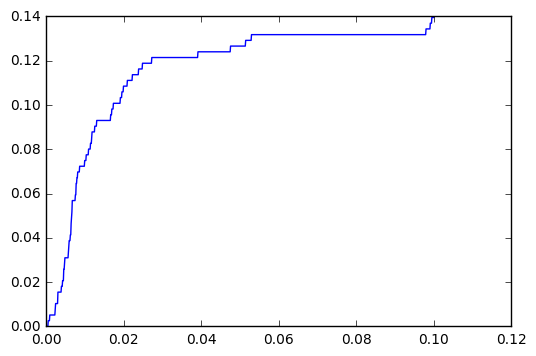

In [126]:
plt.plot(thresholds, results)

Wie finde ich raus, wer den letzten Zug gemacht hat?
-Anhand der Länge der Spiele. Wenn immer Schwarz beginnt, sind Spiele mit ungerader Länge die, bei denen schwarz den letzen Zug hatte.

False negatives minimieren: Situationen, in denen wir aufgegeben haben aber gewonnen hätten. Dabei soll der Threshold maximiert werden -> so früh wie möglich aufhören.
Threshold so hoch wie geht, ohne dass False negatives über x% gehen.




In [11]:
def calculate_winrate(winrate_lists, player):
    """Calculates winrates according to the player: player = 1 black, player = 0 white"""
    for winrates in winrates_list:
        for i, winrate in enumerate(winrates):
            if i % 2 == player:
                winrates[i] = 1 - winrate
                

In [22]:
def naive_find_fn_count(threshold, winrate_lists):
    summe = 0
    for winrate_list in winrate_lists:
        is_th = 0
        for winrate in winrate_list:
            if (1 - winrate <= threshold):
                is_th = 1
        if is_th:
            summe += 1
    return summe